<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/tackle_video_sport_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
cd /content/gdrive/MyDrive/Anomaly_Detection_in_Images/tackle-sport-video/

/content/gdrive/MyDrive/Anomaly_Detection_in_Images/tackle-sport-video


# Supervised Sport Video Classification #

### Import TensorFlow and other libraries ###

In [41]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [42]:

import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [44]:
import os

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
#TensorFlow version
print(tf.__version__)

2.4.1


## Download and explore the dataset ##

In [47]:

train_dir = 'data/train'
validation_dir = 'data/validation'
#test_dir = 'data/test'

In [48]:
train_damaged_dir = os.path.join(train_dir, 'risky')  # directory with our training damaged pictures
train_undamaged_dir = os.path.join(train_dir, 'safe')  # directory with our training undamaged pictures
validation_damaged_dir = os.path.join(validation_dir, 'risky')  # directory with our validation damaged pictures
validation_undamaged_dir = os.path.join(validation_dir, 'safe')  # directory with our validation undamaged pictures
#test_damaged_dir = os.path.join(test_dir, 'damaged')  # directory with our test damaged pictures
#test_undamaged_dir = os.path.join(test_dir, 'undamaged')  # directory with our test undamaged pictures

# Understand the data #

## Let's look at how many damaged and undamaged images are in the training and validation directory: ##

In [49]:

num_damaged_tr = len(os.listdir(train_damaged_dir))
num_undamaged_tr = len(os.listdir(train_undamaged_dir))

num_damaged_val = len(os.listdir(validation_damaged_dir))
num_undamaged_val = len(os.listdir(validation_undamaged_dir))

#num_damaged_ts = len(os.listdir(test_damaged_dir))
#num_undamaged_ts = len(os.listdir(test_undamaged_dir))

total_train = num_damaged_tr + num_undamaged_tr
total_val = num_damaged_val + num_undamaged_val
#total_test = num_damaged_ts + num_undamaged_ts

In [67]:

print('total training risky images:', num_damaged_tr)
print('total training safe images:', num_undamaged_tr)

print('total validation risky images:', num_damaged_val)
print('total validation safe images:', num_undamaged_val)

#print('total test damaged images:', num_damaged_ts)
#print('total test undamaged images:', num_undamaged_ts)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
#print("Total test images:", total_test)

total training risky images: 4
total training safe images: 58
total validation risky images: 4
total validation safe images: 85
--
Total training images: 62
Total validation images: 89


In [68]:
# set up variables
#batch_size = 128


#batch_size = 64


batch_size = 1
#epochs = 5
#IMG_HEIGHT = 150
#IMG_WIDTH = 150

# VGG19, VGG16, Inception
#IMG_HEIGHT = 224
#IMG_WIDTH = 224

# inceptionV3
#IMG_HEIGHT = 299
#IMG_WIDTH = 299


IMG_HEIGHT = 331
IMG_WIDTH = 331

# Data preparation #

In [69]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
#test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [70]:

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 62 images belonging to 2 classes.


In [71]:

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 89 images belonging to 2 classes.


## Visualize training images ##

In [72]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(40,40))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.title(label_batch[n], fontdict={'fontsize':28})
      plt.axis('off')

IndexError: ignored

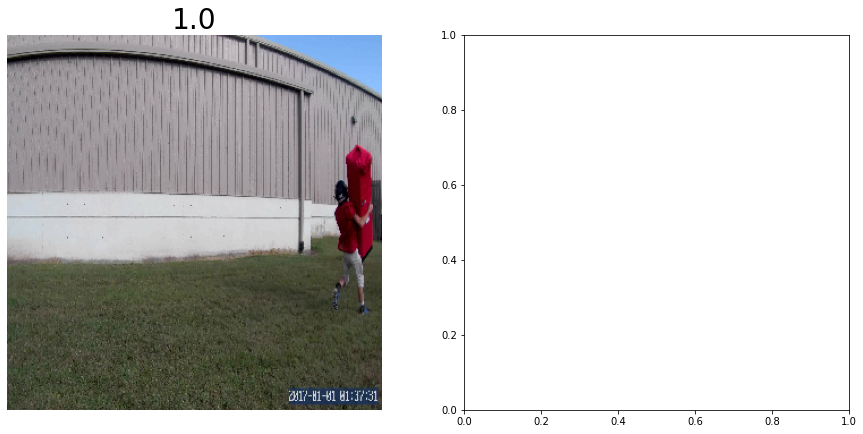

In [73]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## NASNetLarge Pre-trained model ##

In [74]:

from keras.applications.nasnet import NASNetLarge
from keras.preprocessing import image
from keras.applications.nasnet import preprocess_input

In [75]:

from keras import optimizers

In [76]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [77]:
base_model = NASNetLarge(weights='imagenet', include_top=False)

In [78]:
# add a global spatial average pooling layer
x = base_model.output

#x = Dropout(0.5)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)


# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model_NasNet = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_NasNet.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#model_NasNet.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [79]:
from keras.callbacks import EarlyStopping

In [80]:
callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [102]:
history_NasNet = model_NasNet.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=10,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    #callbacks=[callback, cp_callback]
    callbacks=[callback]
)

Epoch 1/10
1/1 [==============================] - 1s 554ms/step - loss: 2.9802e-06 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 455ms/step - loss: 3.6698e-04 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 434ms/step - loss: 3.5763e-07 - accuracy: 1.0000 - val_loss: 5.0229e-04 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 434ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.7020e-04 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 435ms/step - loss: 3.5029e-04 - accuracy: 1.0000 - val_loss: 1.3261e-04 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 440ms/step - loss: 2.7418e-06 - accuracy: 1.0000 - val_loss: 8.9095e-04 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 446ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.7896

## Save the model weights ##

In [103]:
# Save the entire model to a HDF5 file
model_NasNet.save('NasNet/NasNet_model_2.h5')

## Visualize NasNetLarge model ##

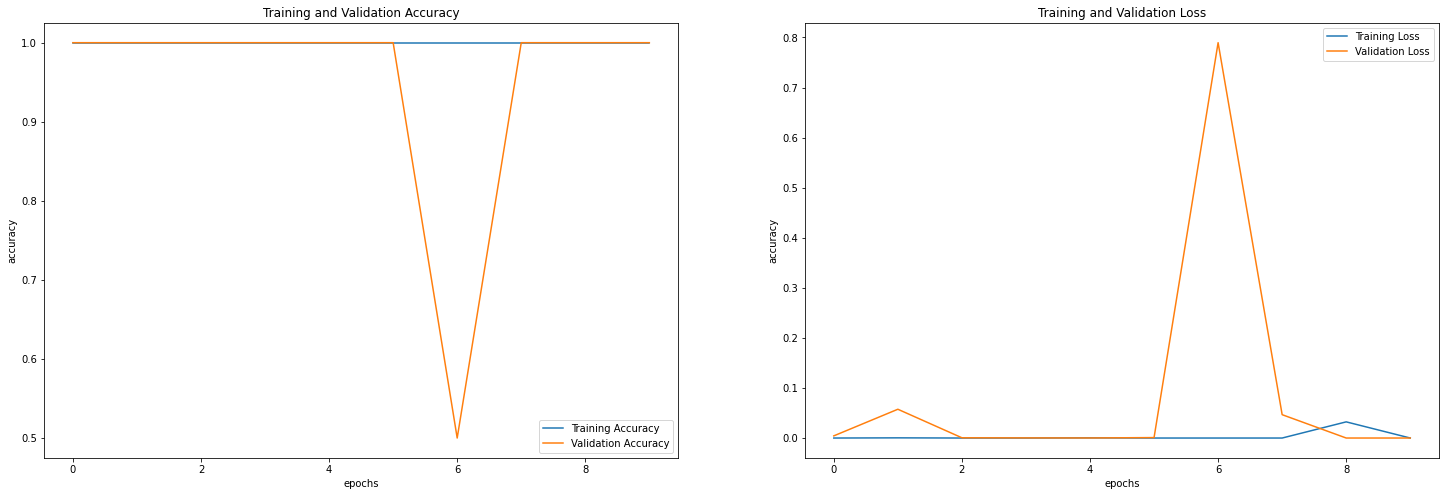

In [104]:
acc = history_NasNet.history['accuracy']
val_acc = history_NasNet.history['val_accuracy']

loss = history_NasNet.history['loss']
val_loss = history_NasNet.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## Evaluation of NasNet model ##

In [105]:
val_loss, test_acc = model_NasNet.evaluate_generator(val_data_gen, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [106]:
true_labels = val_data_gen.classes

In [107]:
predictions = model_NasNet.predict_generator(val_data_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [108]:
import matplotlib.pyplot as plt
import numpy as np

In [109]:
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

In [110]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 0  4]
 [ 0 85]]


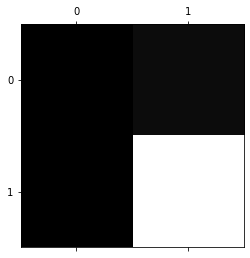

In [111]:

plt.matshow(cm, cmap=plt.cm.gray)
plt.show()

In [112]:
from sklearn.metrics import classification_report

In [113]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.96      1.00      0.98        85

    accuracy                           0.96        89
   macro avg       0.48      0.50      0.49        89
weighted avg       0.91      0.96      0.93        89



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
